In [67]:
from hmmlearn.hmm import GMMHMM
import numpy as np
import pickle
from sklearn.base import BaseEstimator, ClassifierMixin
from statistics import mode
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import confusion_matrix
import pandas as pd

### Extract features and run feature selection

In [68]:
def extract_selected_features(data,indices):
    num_subjects = len(data)
    features = np.empty(num_subjects,dtype=object)
    indices = np.array(indices)
    for recording_idx, recording in enumerate(data):
        recording_data = []
        for segment_idx in range(len(recording)):
            segment = np.asarray(recording[segment_idx])
            selected_features = segment[indices]
            recording_data.append(selected_features)
        recording_data = np.array(recording_data, dtype=np.float32)
        features[recording_idx] = recording_data
    return features

In [69]:
# Extract features
features, labels, recording_ids = [], [], []
with open(f'..\\features_pos1_1.pickle', 'rb') as handle:
    features,labels, recording_ids = pickle.load(handle)

# Features selection
selected_features_idx = []
with open(f'..\\selected_features_HMM.pickle','rb') as handle:
    selected_features_idx = pickle.load(handle)[0]
features = extract_selected_features(features,selected_features_idx)

### Initialize HMM and train the models

In [70]:
n_mix_meal = 7              # Number of mixtures in the GMMHMM for meal model
n_components_meal = 5       # Number of hidden states in the model for meal model
n_mix_nonmeal = 5           # Number of mixtures in the GMMHMM for nonmeal model
n_components_nonmeal = 9    # Number of hidden states in the model for nonmeal model
model_architecture = {0:[n_components_nonmeal, n_mix_nonmeal], 1:[n_components_meal, n_mix_meal]}

In [71]:
class HMM(ClassifierMixin, BaseEstimator):
    def __init__(self, model_arcitechture):
        self.model_arcitechture = model_arcitechture
        self.models = {}
        self.classes_ = []
    
    # Fit HMM model to given training data and parameters
    # X on format (n_samples,) where each sample is of length (n_features)
    def fit(self, X, y, lengths = None):
        self.classes_ = np.unique(y)
        for class_label in self.classes_:
            [n_c, n_m] = self.model_arcitechture[class_label]
            model = GMMHMM(n_components=n_c,n_mix=n_m,algorithm="viterbi")
            class_data = [X[idx] for idx in range(len(y)) if y[idx] == class_label]
            length = None if lengths is None else lengths[class_label]
            model.fit(class_data, length)
            self.models[class_label] = model
        return self
    
    def decode(self, X, lengths = None):
        _, state_sequence = self.models[1].decode(X, lengths=None, algorithm='viterbi')
        return state_sequence

# Prepare data for format to be used in HMM model
# X should be the feature matrix of individual samples, with shape (n_samples, n_features)
# lengths represents length of the individual sequences and sums to n_samples, with shape (n_sequences,)
def prepare_train_data(data, labels):
    lengths = {}
    for recording_labels in labels:
        current_length = 0
        current_class = recording_labels[0]
        for segment_class in recording_labels:
            if segment_class == current_class:
                current_length += 1
            else:
                # Store class_length
                if current_class not in lengths:
                    lengths[current_class] = []
                lengths[current_class].append(current_length)
                # Reset for new class
                current_class = segment_class
                current_length = 1
        if current_class not in lengths:
            lengths[current_class] = []
        lengths[current_class].append(current_length)
    concatenated_data = np.vstack(np.concatenate(data,axis=0))
    concatenated_labels = np.vstack(np.concatenate(labels,axis=0))
    return concatenated_data, concatenated_labels, lengths

# Train hidden markov models based on data
def train_manager(hmm, data, labels):
    #  Prepare data for use in the HMM
    data, labels, lengths = prepare_train_data(data, labels)
    hmm = hmm.fit(data,labels,lengths)
    return hmm

In [72]:
 # Train HMM  based on train set
hmm = HMM(model_architecture)
hmm = train_manager(hmm,features,labels) 


### Predict sequence of states in the model for the event-related recording labels

In [73]:
recording_ids_with_known_labels = ['3BcKJp', '45Meks', 'p3QtK4', '35q2Ws', '35q3JX', '37Bf8z', '3A9kCr', '3av2Qo', 'GqDZNs', 'jVrQKJ', 'KThDxB', 'rj5NKr', '35jaLn', '42Driv', '42sYtA', '44GJdQ', '4NNVK9', 'GpFaF3', 'Q4g6f8']
state_sequences = []
for idx in range(len(recording_ids)):
    if recording_ids[idx] in recording_ids_with_known_labels:
        recording_meal_features = features[idx][labels[idx]==1]
        state_sequence = hmm.decode(recording_meal_features)
        state_sequences.append(state_sequence)

In [74]:
def calculate_seconds_between_the_subsequences(segment_parameters):
    [segment_length,overlap_length,n_segments] = segment_parameters
    step_length = segment_length - overlap_length
    subsequence_length = n_segments*step_length
    return step_length, subsequence_length

### Extract sequence of the recording labels

In [75]:
def find_meta_data(id):
    root_folder_path = f'..\\Data'
    # Loop through each academic year in data folder
    root_folder_path_os = os.path.abspath(root_folder_path)
    for year_folder in os.listdir(root_folder_path_os):
        year_folder_path = os.path.join(root_folder_path_os,year_folder)
        # Ensure directory (folder)
        if os.path.isdir(year_folder_path): 
            # Loop through each subject in year
            for subject_folder in os.listdir(year_folder_path):
                subject_folder_path = os.path.join(year_folder_path,subject_folder)
                # Ensure directory (folder)
                if os.path.isdir(subject_folder_path): 
                    # Loop through each recording for subject
                    for recording_folder in os.listdir(subject_folder_path):
                        recording_folder_path = os.path.join(subject_folder_path,recording_folder)
                        if recording_folder == id:
                            if os.path.isdir(recording_folder_path):
                                metadata_file_path = os.path.join(recording_folder_path, f"{recording_folder}.json")
                                metadata_labels_file = os.path.join(recording_folder_path, f"{recording_folder}.txt") 
                                return metadata_file_path, metadata_labels_file
    return None

In [76]:
def find_labeled_states(id):
    metadata_file, labels_file = find_meta_data(id)

    # Extract labels from metadata files
    meta_data = ""
    audio_offset = 0
    with open(metadata_file, 'r') as file:
        meta_data = json.load(file)
    if "audio_offset" in meta_data:
        audio_offset = meta_data["audio_offset"]
    meal_start, meal_end, meal_type = meta_data["mealStart"]-audio_offset, meta_data["mealEnd"]-audio_offset, meta_data["mealType"]

    labels_parsed = []
    with open(labels_file,"r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 3:
                continue
            start, end, ltype = float(parts[0]), float(parts[1]), parts[2].lower()
            if start > meal_start and end < meal_end:
                labels_parsed.append((start-meal_start, end-meal_start, ltype))

    return labels_parsed, meal_type
    

In [77]:
def convert_labels_sequence(labels_parsed, segment_parameters,prediction_length):
    [segment_length,overlap_length,_] = segment_parameters
    sr = 22050
    segment_samples = segment_length * sr
    overlap_samples = overlap_length* sr
    step_samples = segment_samples - overlap_samples

    label_value = {
        'chew': 1,
        'swallow': 2,
    }

    state_labels = np.zeros(prediction_length,dtype=int)
    for (start, end, type) in labels_parsed:
        start_samples, end_samples = start*sr, end*sr
        start_segment, end_segment = (start_samples - overlap_samples)//step_samples, (end_samples-overlap_samples)//step_samples
        state_labels[int(start_segment):int(end_segment)] = label_value[type]

    return state_labels

### Plot the evolution of hidden states during the meal

In [87]:
def plot_evolution(state, labeled_states, step_length, subsequence_length, id, meal_type):
    time = np.linspace(subsequence_length,len(state)*step_length,len(state))
    label_color_map = {
        'chew': 'green',
        'swallow': 'red',
    }

    label_shown = set()

    plt.figure()
    for idx, (start, end, type) in enumerate(labeled_states):
        color = label_color_map[type]
        label = type if type not in label_shown else None
        plt.axvspan(start, end, color=color, alpha=0.3, label=label)
        label_shown.add(label)
    plt.plot(time,state,color='k',linestyle='-',linewidth=1,label='Predicted')
    plt.ylim(-0.1,4.1)
    plt.yticks([0,1,2,3,4],['0','1','2','3','4'])
    plt.ylabel('Hidden state')
    plt.xlabel('Time [s]')
    plt.text(time[-1],-0.8,f'Recording id: {id}',ha='right',va='bottom')
    plt.text(time[-1],-1,f'Meal type: {meal_type}',ha='right',va='bottom')
    plt.tight_layout()
    plt.legend()

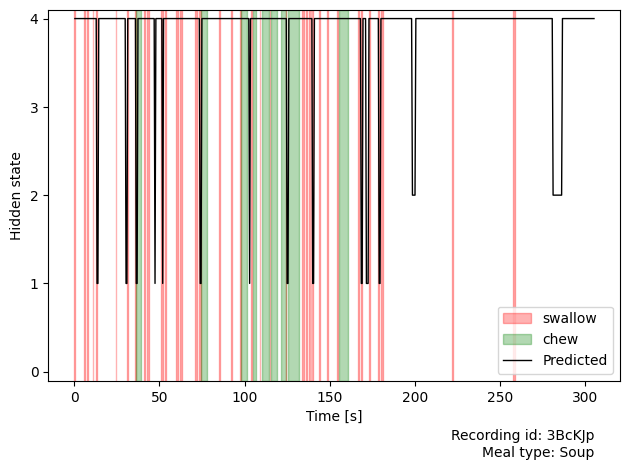

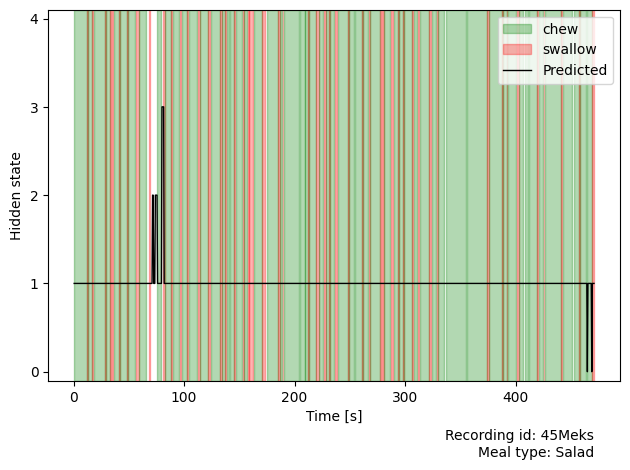

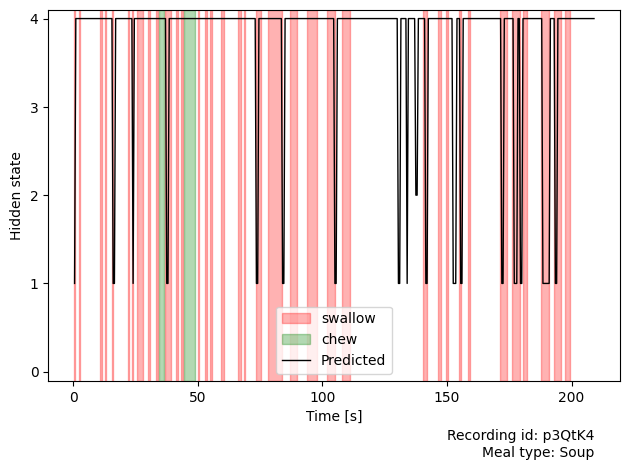

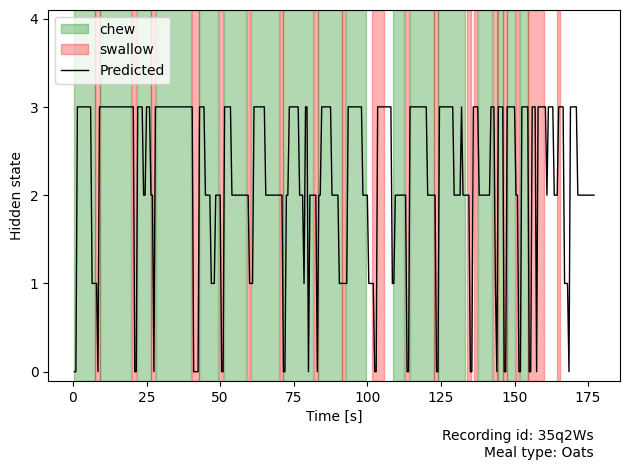

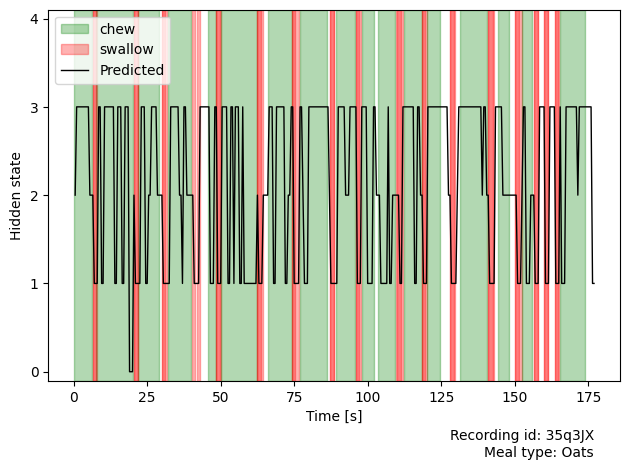

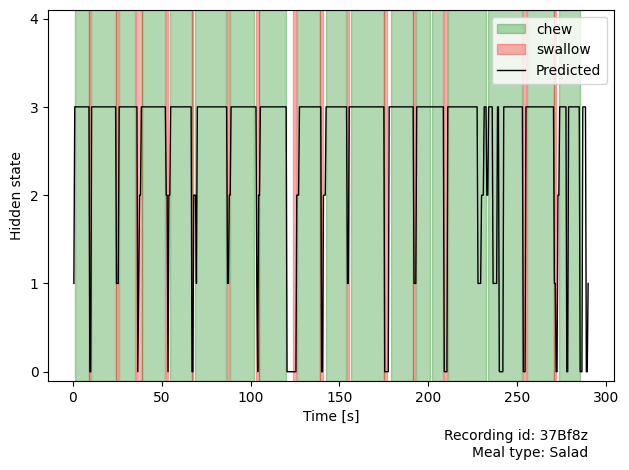

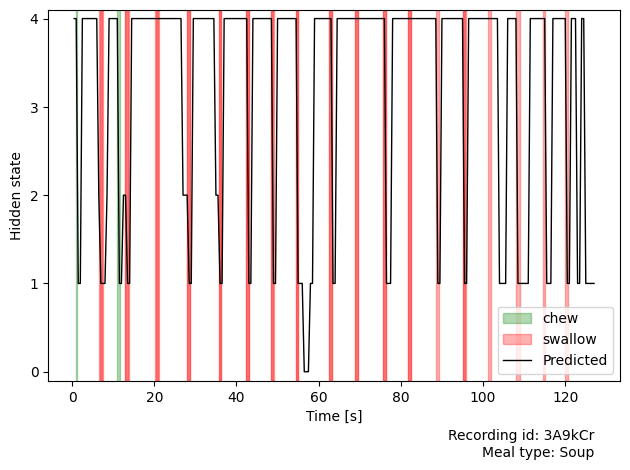

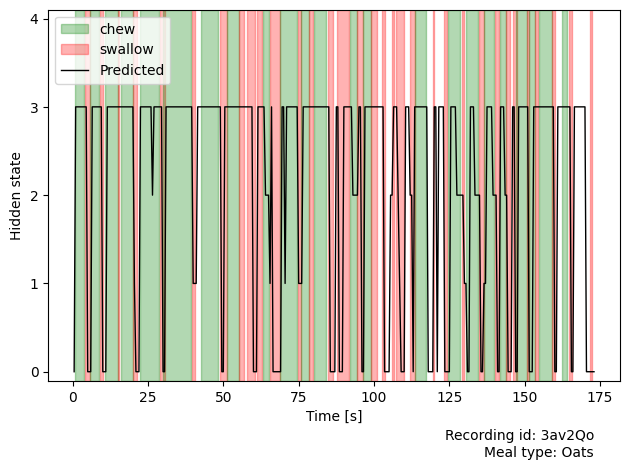

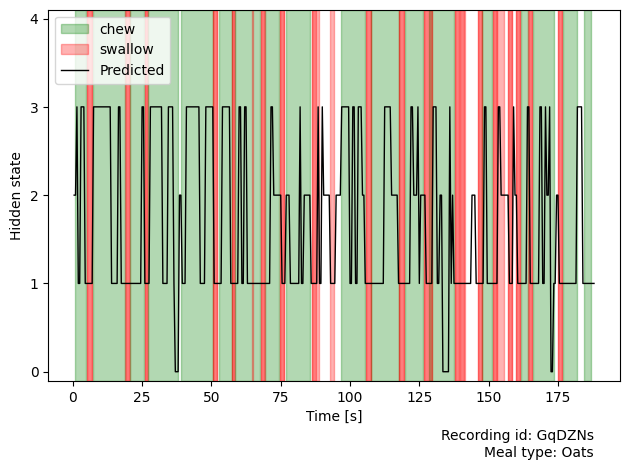

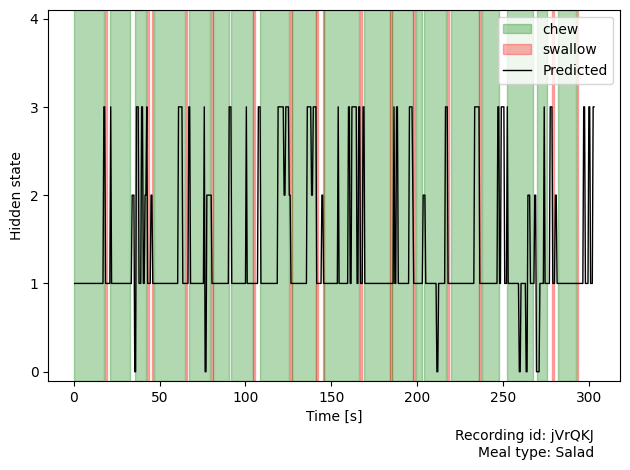

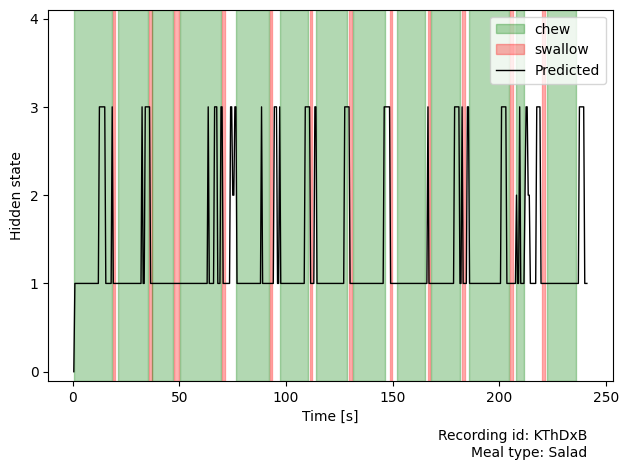

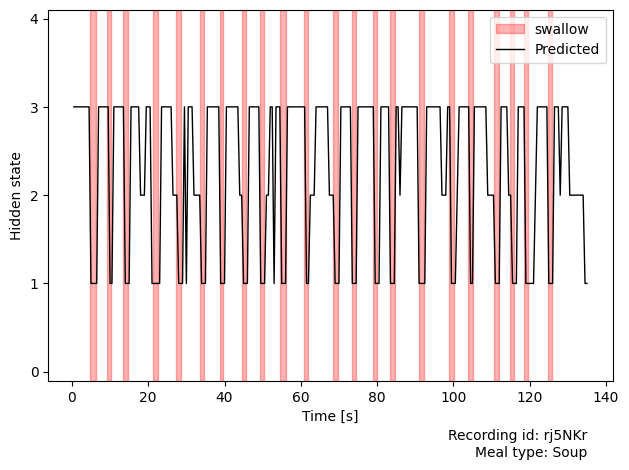

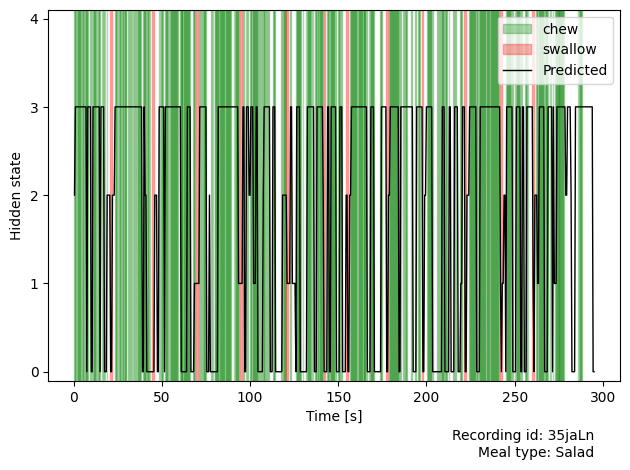

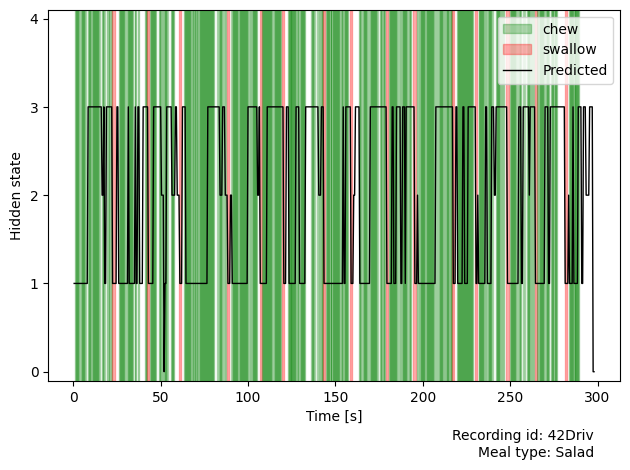

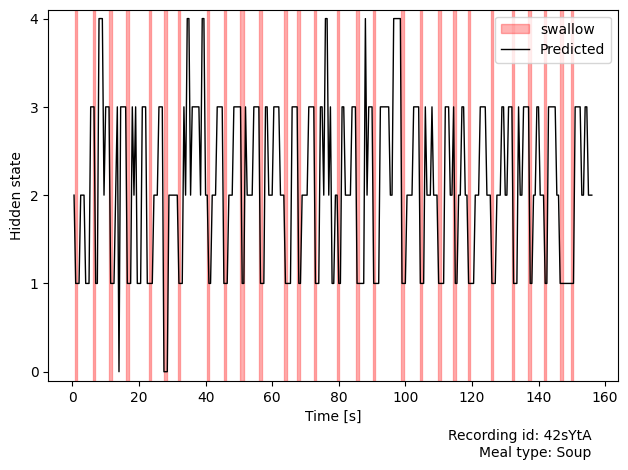

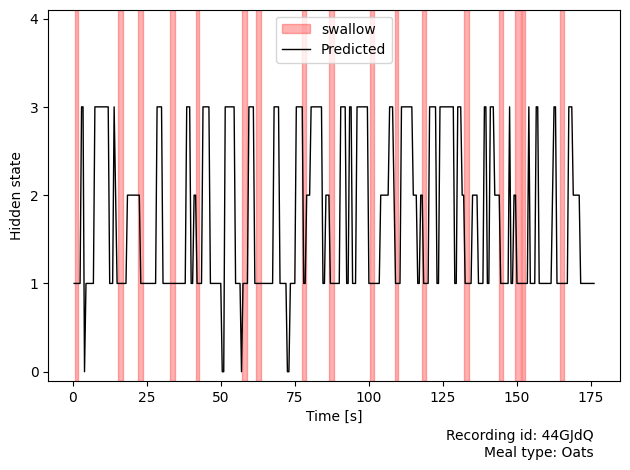

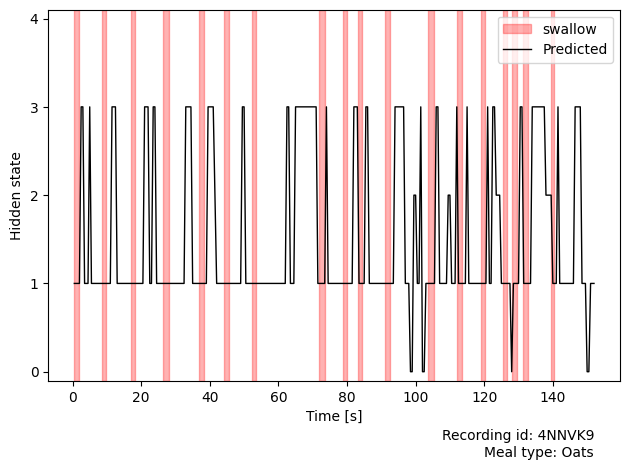

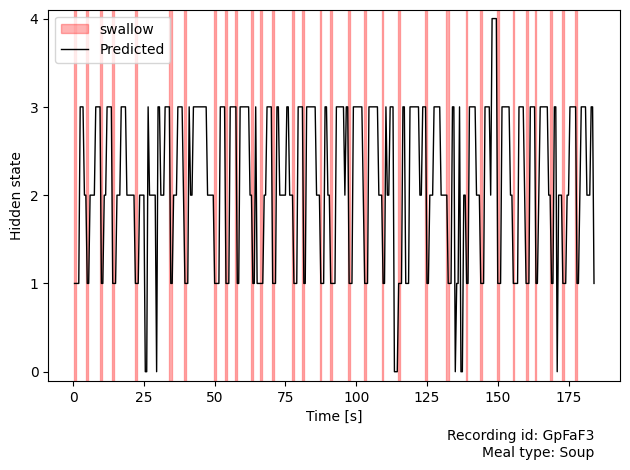

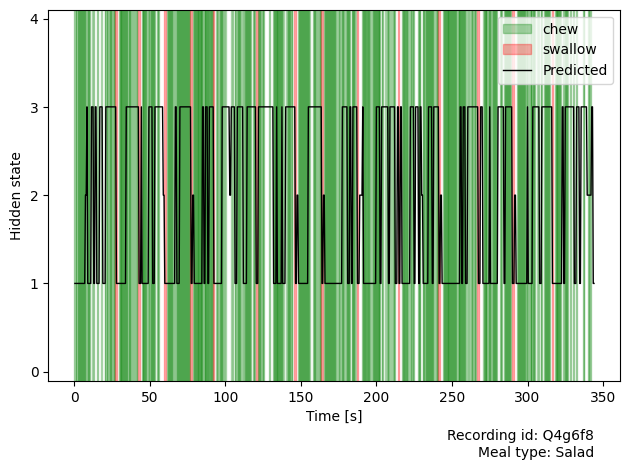

In [90]:
step_length, subsequence_length = calculate_seconds_between_the_subsequences([1,0.5,1])
sequence_labels = []
for recording_idx in range(len(state_sequences)):
    recording_id = recording_ids_with_known_labels[recording_idx]
    labels_parsed, meal_type = find_labeled_states(recording_id)
    state_labels = convert_labels_sequence(labels_parsed,[1,0.5,1],len(state_sequences[recording_idx]))
    plot_evolution(state_sequences[recording_idx],labels_parsed,step_length,subsequence_length,recording_id,meal_type)
    sequence_labels.append(state_labels)
    

### Compute measures

In [80]:
import seaborn as sns

In [96]:
def measure_similarity(state_sequence, state_labels):
    num_labels, num_states = 3,5
    overlap = np.zeros((num_labels,num_states),dtype=int)
    for i in range(len(state_labels)):
        l = state_labels[i]
        s = state_sequence[i]
        overlap[l,s] += 1

    df = pd.DataFrame(overlap, 
                      index = ['background','chew','swallow'],
                      columns = [f'State {i}' for i in range(num_states)])
    
    plt.figure()
    sns.heatmap(df,annot=True,fmt='d',cmap='Blues')
    plt.xlabel('Hidden state')
    plt.ylabel('Manually assigned labels')
    plt.show()

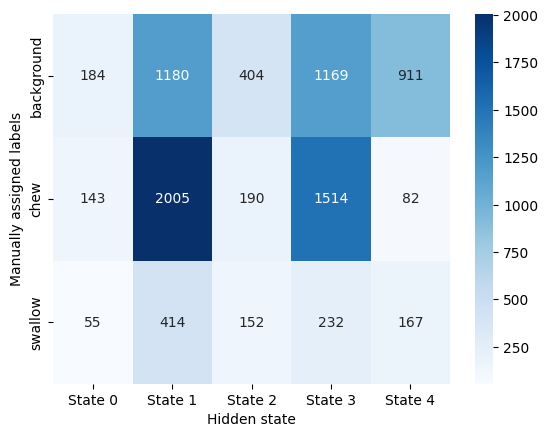

In [97]:
sequence_states_concatenated = np.concatenate(state_sequences, axis=0)
sequence_labels_concatenated = np.concatenate(sequence_labels, axis=0)
measure_similarity(sequence_states_concatenated, sequence_labels_concatenated)